In [1]:
# This is a Bayesian Neural Network implementation using TensorFlow for a simple y = sin(x) function

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# Check if GPU is available
print("GPU Available: ", tf.test.is_gpu_available())
print("GPU Name: ", tf.test.gpu_device_name())

In [ ]:
# Define the parameters for the Burger's equation
nu = 0.2 / np.pi  # Viscosity
N = 1000  # Number of data points

# Generate the spatial domain
x = np.linspace(-1, 1, N)
t = np.linspace(0, 1, N)
X, T = np.meshgrid(x, t)

# Initial condition
u0 = -np.sin(np.pi * x)

# Generate the dataset
def burgers_exact(x, t, nu):
    return -2 * nu * np.pi * np.sin(np.pi * (x - 4 * nu * t)) * np.exp(-np.pi**2 * nu * t)
# Exact solution: u(x, t) = -2 * nu * pi * sin(pi * (x - 4 * nu * t)) * exp(-pi^2 * nu * t)
# If t = 0, u(x, 0) = -2 * nu * pi * sin(pi * x) = -2 * 0.01/pi * pi * sin(pi * x) = -0.02 * sin(pi * x)
# If t = 1, u(x, 1) = -2 * nu * pi * sin(pi * (x - 4 * nu)) = -2 * 0.01/pi * pi * sin(pi * (x - 4 * 0.01/pi)) = -0.02 * sin(pi * (x - 4 * 0.01/pi))

U_1D = burgers_exact(x, t, nu)
U = burgers_exact(X, T, nu)

# Plot sizes of all the data
print("x shape:", x.shape)
print("t shape:", t.shape)
print("u0:", u0.shape)
print("U_1D shape:", U_1D.shape)
print("X shape:", X.shape)
print("T shape:", T.shape)
print("U shape:", U.shape)

plt.figure(figsize=(8, 4))
plt.plot(x, U_1D)
plt.xlabel('x')
plt.ylabel('u')
plt.title('1D Burgers Equation Data - 1 Snapshot')
plt.show()

# Plot the initial condition
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, T, U, shading='auto')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("Burger's Equation Solution")
plt.show()

plt.figure(figsize=(8, 4))
for i in range(0, 1000, 100):
    plt.plot(x, U[i, :]) # i is the time index, : is the spatial index
plt.xlabel('x')
plt.ylabel('u')
plt.title('1D Burgers Equation Data - 1 Snapshot')
plt.show()

In [50]:
def a_pinn(model, x, t, u, nu):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            #u = model.forward(tf.concat([x], axis=1))
            u = model.forward(x)
        u_x = tape.gradient(u, x)
    u_xx = tape2.gradient(u_x, x)
    #u_t = tape.gradient(u, t)
    residual = u * u_x - nu * u_xx
    return residual

def n_pinn(model, x, t, u, nu, scheme):
    dx = x[1] - x[0] # Assuming uniform grid  
    xE, xW = x + dx, x - dx
    uE, uW = model.forward(xE), model.forward(xW)

    if scheme == 'uw1':
        u_x = (u - uW) / (x - xW)
        u_xx = (uE - 2 * u + uW) / (x - xW)**2
    elif scheme == 'uw2':
        uWW = model.forward(x - 2 * dx)
        u_x = (3 * u - 4 * uW + uWW) / (2 * dx)
        uEE = model.forward(x + 2 * dx)
        u_xx = (-uEE + 4 * uE - 5 * u + 2 * uW) / dx**2

    residual = u * u_x - nu * u_xx
    return residual

def can_pinn(model, x, t, u, nu, scheme):
    dx = x[1] - x[0] # Assuming uniform grid
    xE, xW = x + dx, x - dx # u(x-dx) = uW, u(x) = u, u(x+dx) = uE
    uE, uW = model.forward(xE), model.forward(xW)

    if scheme == 'uw1':
        '''uE, uW = model.forward(xE), model.forward(xW)
        a1, a2, a3 = 1, a1 * dx / 2, a1 * dx**2 / 3
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xE, xW)
        uE_x, uW_x = tape.gradient(uE, xE), tape.gradient(uW, xW)'''

    elif scheme == 'uw2':
        
        with tf.GradientTape(persistent=True) as tape2_xE, tf.GradientTape(persistent=True) as tape2_xW, tf.GradientTape(persistent=True) as tape2_x:
            tape2_xE.watch(xE)
            tape2_xW.watch(xW)
            tape2_x.watch(x)
            with tf.GradientTape(persistent=True) as tape_xE, tf.GradientTape(persistent=True) as tape_xW, tf.GradientTape(persistent=True) as tape_x:
                tape_xE.watch(xE)
                tape_xW.watch(xW)
                tape_x.watch(x)
                uE, uW, u = model.forward(xE), model.forward(xW), model.forward(x)
            uE_x, uW_x, u_x = tape_xE.gradient(uE, xE), tape_xW.gradient(uW, xW), tape_x.gradient(u, x)
        uE_xx, uW_xx, u_xx = tape2_xE.gradient(uE_x, xE), tape2_xW.gradient(uW_x, xW), tape2_x.gradient(u_x, x)

        uEm_uw2 = u + u_x*dx/2
        uEp_uw2 = uE - uE_x*dx/2
        uWm_uw2 = uW + uW_x*dx/2
        uWp_uw2 = u - u_x*dx/2
        #uE_uw2 = tf.where(u_x > 0, uEm_uw2, uEp_uw2)
        #uW_uw2 = tf.where(u_x > 0, uWm_uw2, uWp_uw2)
        uE_uw2 = tf.where(tf.greater_equal(u_x, 0.0), uEm_uw2, uEp_uw2)
        uW_uw2 = tf.where(tf.greater_equal(u_x, 0.0), uWm_uw2, uWp_uw2)    
        u_uw2 = (uE_uw2 + uW_uw2) / 2
        u_x_uw2 = (uE_uw2 - uW_uw2) / dx

        uEm_x_uw2 = u_x + u_xx * dx / 2
        uEp_x_uw2 = uE_x - uE_xx * dx / 2
        uWm_x_uw2 = uW_x + uW_xx * dx / 2
        uWp_x_uw2 = u_x - u_xx * dx / 2
        #uE_x_uw2 = tf.where(u_x > 0, uEm_x_uw2, uEp_x_uw2)
        #uW_x_uw2 = tf.where(u_x > 0, uWm_x_uw2, uWp_x_uw2)
        uE_x_uw2 = tf.where(tf.greater_equal(u_x, 0.0), uEm_x_uw2, uEp_x_uw2)
        uW_x_uw2 = tf.where(tf.greater_equal(u_x, 0.0), uWm_x_uw2, uWp_x_uw2) 
        u_xx_uw2 = (uE_x_uw2 - uW_x_uw2) / dx

    residual = u_uw2 * u_x_uw2 - nu * u_xx_uw2  
    
    # save first and second terms of residual into a dataframe
    first_term = u_uw2 * u_x_uw2
    second_term = nu * u_xx_uw2

    return residual, first_term, second_term, u_uw2, u_x_uw2


def pinn_loss(model, x, t, u0, nu):
    # Initial condition loss
    #u_pred_initial = model.forward(tf.concat([x, tf.zeros_like(x)], axis=1))
    #loss_initial = tf.reduce_mean(tf.square(u_pred_initial - u0))

    # Boundary condition loss
    #u_pred_left = model.forward(tf.concat([tf.ones_like(t) * x[0], t], axis=1))
    #u_pred_right = model.forward(tf.concat([tf.ones_like(t) * x[-1], t], axis=1))
    #loss_boundary = tf.reduce_mean(tf.square(u_pred_left)) + tf.reduce_mean(tf.square(u_pred_right))
    u_pred_left = model.forward([x[0]])
    u_pred_right = model.forward([x[-1]])
    loss_boundary = tf.reduce_mean(tf.square(u_pred_left)) + tf.reduce_mean(tf.square(u_pred_right))
    #loss_boundary = tf.reduce_mean(tf.square(u_pred_left - 0)) + tf.reduce_mean(tf.square(u_pred_right - 0))

    '''# PDE residual loss
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        u_pred = model(tf.concat([x, t], axis=1))
    residual = pde_residual(u_pred, x, t, nu)
    loss_pde = tf.reduce_mean(tf.square(residual))'''

    # Total loss
    total_loss = loss_boundary 
    return total_loss

X_tf shape: (200, 1000)
X_tf type: float64
Y_tf shape: (200, 1000)
Y_tf type: float64
X_train_time shape: (120, 1000)
Y_train_time shape: (120, 1000)
X_val_time shape: (80, 1000)
Y_val_time shape: (80, 1000)
<BatchDataset element_spec=(TensorSpec(shape=(128, 1000), dtype=tf.float64, name=None), TensorSpec(shape=(128, 1000), dtype=tf.float64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(128, 1000), dtype=tf.float64, name=None), TensorSpec(shape=(128, 1000), dtype=tf.float64, name=None))>


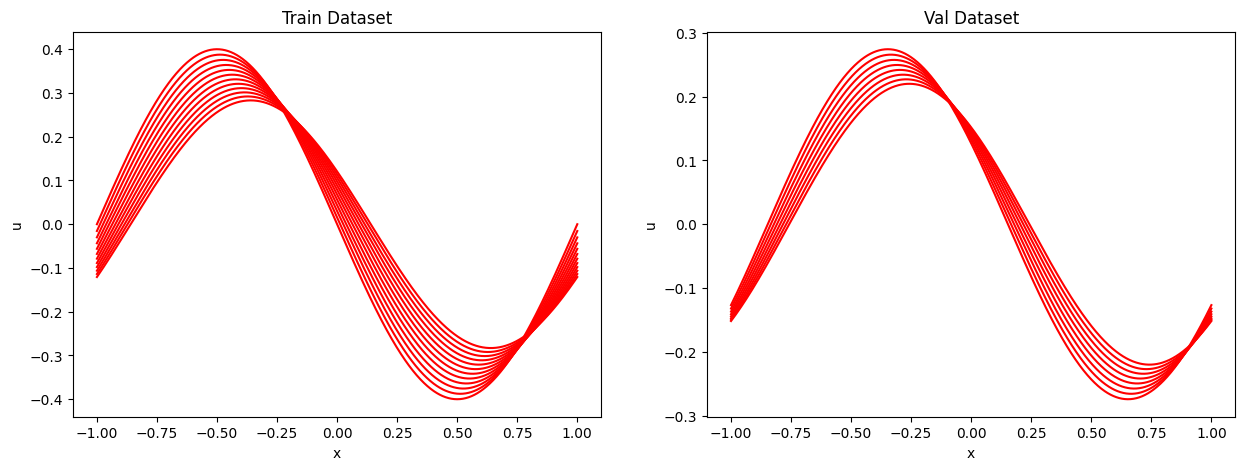

In [59]:
X_tf = X[::5, :]
Y_tf = U[::5, :]
print('X_tf shape:', X_tf.shape)
print('X_tf type:', X_tf.dtype)
print('Y_tf shape:', Y_tf.shape)
print('Y_tf type:', Y_tf.dtype)

# So we have 1000 time and 1000 data points
# We want to split training and validation data for the time dimension, and randomly shuffle the time dimension
# For batching, we want to split the data into batches of 128 data points for the time dimension

batch_size = 128

# Split the data into training and validation sets for the time dimension
time_indices = np.arange(X_tf.shape[0])
#np.random.shuffle(time_indices)

train_time_indices = time_indices[:int(0.6 * len(time_indices))]
val_time_indices = time_indices[int(0.6 * len(time_indices)):]

X_train_time = X_tf[train_time_indices, :]
Y_train_time = Y_tf[train_time_indices, :]
X_val_time = X_tf[val_time_indices, :]
Y_val_time = Y_tf[val_time_indices, :]
print('X_train_time shape:', X_train_time.shape)
print('Y_train_time shape:', Y_train_time.shape)
print('X_val_time shape:', X_val_time.shape)
print('Y_val_time shape:', Y_val_time.shape)

# Create batches for training and validation sets
train_dataset_time = tf.data.Dataset.from_tensor_slices((X_train_time, Y_train_time))
train_dataset_time = train_dataset_time.shuffle(buffer_size=10000).batch(batch_size, drop_remainder=True)

val_dataset_time = tf.data.Dataset.from_tensor_slices((X_val_time, Y_val_time))
val_dataset_time = val_dataset_time.batch(batch_size, drop_remainder=True)

print(train_dataset_time)
print(val_dataset_time)

# Plot the train and val dataset for u, v, p in a subplot for both train and val
plt.figure(figsize=(15, 5))
# Plot train and val dataset for u
plt.subplot(1, 2, 1)
for i in range(0, X_train_time.shape[0], 10):
    plt.plot(X_train_time[i, :], Y_train_time[i, :], 'r')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title('Train Dataset')
plt.subplot(1, 2, 2)
for i in range(0, X_val_time.shape[0], 10):
    plt.plot(X_val_time[i, :], Y_val_time[i, :], 'r')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title('Val Dataset')
plt.show()

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the neural network architecture
class BayesianNeuralNetwork:
    def __init__(self, input_dim, hidden1, hidden2, output_dim, dropout_rate=0.):
        # Initialize weights and biases as TensorFlow variables
        initializer = tf.initializers.GlorotUniform()

        # Define trainable parameters (weights and biases)
        self.weights = [
            tf.Variable(initializer([input_dim, hidden1]), dtype=tf.float32),
            tf.Variable(initializer([hidden1, hidden2]), dtype=tf.float32),
            tf.Variable(initializer([hidden2, output_dim]), dtype=tf.float32)
        ]
        
        self.biases = [
            tf.Variable(tf.zeros([hidden1]), dtype=tf.float32),
            tf.Variable(tf.zeros([hidden2]), dtype=tf.float32),
            tf.Variable(tf.zeros([output_dim]), dtype=tf.float32)
        ]

        self.dropout_rate = dropout_rate

    def forward(self, X, training=True):
        # Layer 1 with tanh activation
        hidden1 = tf.matmul(X, self.weights[0]) + self.biases[0]
        hidden1_activation = tf.nn.tanh(hidden1)
        if training:
            hidden1_activation = tf.nn.dropout(hidden1_activation, rate=self.dropout_rate)
        
        # Layer 2 with tanh activation
        hidden2 = tf.matmul(hidden1_activation, self.weights[1]) + self.biases[1]
        hidden2_activation = tf.nn.tanh(hidden2)
        if training:
            hidden2_activation = tf.nn.dropout(hidden2_activation, rate=self.dropout_rate)
        
        # Output layer (linear activation)
        output = tf.matmul(hidden2_activation, self.weights[2]) + self.biases[2]
        return output

# Initialize the Bayesian neural network
input_dim = 1
hidden1 = 256
hidden2 = 256
output_dim = 1

model = BayesianNeuralNetwork(input_dim, hidden1, hidden2, output_dim)

# Prepare the optimizer
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate)  # Adam often works better for Bayesian methods

# Training parameters
epochs = 20000
print_interval = 100
best_rmse = float('inf')
loss_all = []
loss_all_pde = []
loss_all_conditions = []
loss_all_data = []
first_term_all = []
second_term_all = []
val_loss_all = []
u_uw2_all = []
u_x_uw2_all =[]

X_train_time = X_tf[train_time_indices, :]
Y_train_time = Y_tf[train_time_indices, :]
X_val_time = X_tf[val_time_indices, :]
Y_val_time = Y_tf[val_time_indices, :]
print('X_train_time shape:', X_train_time.shape)
print('Y_train_time shape:', Y_train_time.shape)
print('X_val_time shape:', X_val_time.shape)
print('Y_val_time shape:', Y_val_time.shape)
# Flatten the data
X_train_time = X_train_time.flatten().reshape(-1, 1)
Y_train_time = Y_train_time.flatten().reshape(-1, 1)
X_val_time = X_val_time.flatten().reshape(-1, 1)
Y_val_time = Y_val_time.flatten().reshape(-1, 1)
# Convert all to tensor
X_train_time = tf.convert_to_tensor(X_train_time, dtype=tf.float32)
Y_train_time = tf.convert_to_tensor(Y_train_time, dtype=tf.float32)
X_val_time = tf.convert_to_tensor(X_val_time, dtype=tf.float32)
Y_val_time = tf.convert_to_tensor(Y_val_time, dtype=tf.float32)

# Training loop with validation
with tf.device('/device:GPU:0'):
    for epoch in range(1, epochs + 1):
        # Training step
        with tf.GradientTape() as tape:
            Y_pred = model.forward(X_train_time, training=True)
            loss_data = tf.reduce_mean(tf.square(Y_train_time - Y_pred))
            residual, first_term, second_term, u_uw2, u_x_uw2 = can_pinn(model, X_train_time, T, Y_train_time, nu, 'uw2')
            first_term_all.append(first_term)  
            second_term_all.append(second_term)
            u_uw2_all.append(u_uw2)
            u_x_uw2_all.append(u_x_uw2)
            loss_pde = tf.reduce_mean(tf.square(residual)) 
            loss = loss_data + loss_pde
            
        gradients = tape.gradient(loss, model.weights + model.biases)
        clipped_gradients = [tf.clip_by_value(g, -1.0, 1.0) for g in gradients]
        optimizer.apply_gradients(zip(clipped_gradients, model.weights + model.biases))

        loss_all_data.append(loss_data)
        loss_all_pde.append(loss_pde)
        loss_all.append(loss)

        # Validation step
        val_loss = 0
        Y_val_pred = model.forward(X_val_time, training=False)
        val_loss += tf.reduce_mean(tf.square(Y_val_time - Y_val_pred))
        val_loss_all.append(val_loss)

        if epoch % print_interval == 0 or epoch == 1:
            print(f'Epoch {epoch} --- Loss = {loss.numpy():.6f} --- Validation Loss = {val_loss.numpy():.6f} --- Loss components: Data {loss_data.numpy()}, PDE {loss_pde.numpy()}')
            rmse_train = tf.sqrt(tf.reduce_mean((y - model.forward(x))**2))
            print(f"RMSE: {rmse_train.numpy():.10f}")

            if rmse_train < best_rmse:
                best_rmse = rmse_train
                MAP_weights = model.weights
                MAP_biases = model.biases
                best_epoch = epoch
                print("Improved RMSE. Saved weights and biases.")

'''
with tf.device('/device:GPU:0'):
    for epoch in range(1, epochs + 1):
        for step, (X_batch, Y_batch) in enumerate(dataset):
            with tf.GradientTape() as tape:
                # Forward pass with current batch
                Y_pred = model.forward(X_batch)
                loss_data = tf.reduce_mean(tf.square(Y_batch - Y_pred))
                #loss_pde = nt_pinn(model, X_batch, T, Y_batch, nu, 'uw2')
                residual, first_term, second_term = can_pinn(model, X_tf, T, Y_tf, nu, 'uw2')
                # save first and second terms of residual into a dataframe for every epoch
                first_term_all.append(first_term)  
                second_term_all.append(second_term)
                loss_pde = tf.reduce_mean(tf.square(residual)) 

                alpha = max(0.1, 1 - epoch / 1000)
                beta = min(1.0, epoch / 1000)
                #loss = loss_data * beta + loss_pde * alpha
                loss = loss_data + loss_pde
                loss_all_data.append(loss_data)
                loss_all_pde.append(loss_pde)
                loss_all_conditions.append(loss_conditions)
                loss_all.append(loss)
                
                # Debugging loss values
                if tf.math.is_nan(loss):
                    print(f"NaN detected in loss at Epoch {epoch}, Step {step}")
                    print(f"Loss components: Data {loss_data.numpy()}, PDE {loss_pde.numpy()}, Conditions {loss_conditions.numpy()}")
                    raise ValueError("NaN in loss function")
    
            # Compute and clip gradients
            gradients = tape.gradient(loss, model.weights + model.biases)
            clipped_gradients = [tf.clip_by_value(g, -1.0, 1.0) for g in gradients]
            optimizer.apply_gradients(zip(clipped_gradients, model.weights + model.biases))
        
        # Print epoch summary
        if epoch % print_interval == 0 or epoch == 1:
            print(f'Epoch {epoch} --- Loss = {loss.numpy():.6f} --- Loss components: Data {loss_data.numpy()}, PDE {loss_pde.numpy()}, Conditions {loss_conditions.numpy()}')
            rmse_train = tf.sqrt(tf.reduce_mean((Y_tf - model.forward(X_tf))**2))
            print(f"RMSE: {rmse_train.numpy():.10f}")
    
            # Save weights if improvement
            if rmse_train < best_rmse:
                best_rmse = rmse_train
                MAP_weights = model.weights
                MAP_biases = model.biases
                best_epoch = epoch
                print("Improved RMSE. Saved weights and biases.")
                '''


# After training, plot the model predictions
print(f"Best Epoch at: {best_epoch}")
plt.figure(figsize=(8, 6))
plt.plot(X, Y, alpha=1, label='True Data')
# Sort X for better visualization of the prediction curve
sorted_indices = np.argsort(X.squeeze())
X_sorted = X[sorted_indices]
Y_pred_sorted = Y_pred.numpy()[sorted_indices]
plt.plot(X_sorted, Y_pred_sorted, color='red', label='Model Prediction', linewidth=2)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Bayesian Neural Network Fit to sin(X)")
plt.legend()
plt.show()

c:\Users\User\anaconda3\envs\goat\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


X_train_time shape: (120, 1000)
Y_train_time shape: (120, 1000)
X_val_time shape: (80, 1000)
Y_val_time shape: (80, 1000)


ResourceExhaustedError: {{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[120000,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:MatMul]

In [ ]:
u_array = np.array(u_uw2_all)
print(u_array.shape)
u_mse = np.mean(u_array, axis=1)
print(u_mse.shape)

plt.figure(figsize=(8, 6))
plt.plot(u_array[0, :], label='u_uw2')
plt.show()


In [ ]:
# Print RMSE
model.weights = MAP_weights
model.biases = MAP_biases
U_pred = model.forward(X_tf)
rmse = tf.sqrt(tf.reduce_mean(tf.square(Y_tf - U_pred)))
print("Best epoch at: ", best_epoch)
print(f"RMSE: {rmse.numpy():.8f}")

# Convert loss to anti-log:
print(f"Loss: {(loss.numpy()):.8f}")

# Plot the loss if any of the required loss components are available
plt.figure(figsize=(8, 6))
if loss_all:
    plt.plot(loss_all, linewidth=5, label=f'Total Loss {loss_all[-1].numpy():.6f}')
if loss_all_data:
    plt.plot(loss_all_data, label=f'Data Loss {loss_all_data[-1].numpy():.6f}')
if loss_all_pde:
    plt.plot(loss_all_pde, label=f'PDE Loss {loss_all_pde[-1].numpy():.6f}')
if loss_all_conditions:
    plt.plot(loss_all_conditions, label=f'Conditions Loss {loss_all_conditions[-1].numpy():.6f}')
if val_loss_all:
    plt.plot(val_loss_all, label=f'Validation Loss {val_loss_all[-1].numpy():.6f}')
plt.axhline(y=0, color='b', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.yscale('log')
# save the plot
plt.savefig("loss_plot_CANPINN_NS_PDE.png")
plt.show()

# Plot true vs predicted
plt.figure(figsize=(8, 6))
plt.plot(x, Y_tf, alpha=1, label='True Data')
plt.plot(x, U_pred, color='red', label='Model Prediction', linewidth=2)
plt.xlabel("True Y")
plt.ylabel("Predicted Y")
rmse = tf.sqrt(tf.reduce_mean(tf.square(Y_tf - U_pred)))
plt.title(f"True vs Predicted Y (RMSE: {rmse.numpy():.8f})")
plt.legend()
plt.show()

first_term_all_array = np.array(first_term_all) 
second_term_all_array = np.array(second_term_all)
u_array = np.array(u_uw2_all)
u_x_array = np.array(u_x_uw2_all)

print("First term shape:", first_term_all_array.shape)
print("Second term shape:", second_term_all_array.shape)

# Cal the mean square error for the first and second term of the residual of 2nd dim for all 1st dim
first_term_mse = np.mean(first_term_all_array, axis=1)
second_term_mse = np.mean(second_term_all_array, axis=1)
u_mse = np.mean(u_array, axis=1)
u_x_mse = np.mean(u_x_array, axis=1)


print("First term MSE:", first_term_mse.shape)
print("Second term MSE:", second_term_mse.shape)

plt.figure(figsize=(8, 6))
plt.plot(first_term_mse, label='First Term')
plt.plot(second_term_mse, label='Second Term')
plt.plot(u_mse, label='u Term')
plt.plot(u_x_mse, label='u_x Term')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('First and Second Term of the Residual')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(x, Y_tf, alpha=1, label='True Data')
plt.plot(x, np.mean(u_x_array, axis=0), color='red', label='Model Prediction', linewidth=2)
rmse = tf.sqrt(tf.reduce_mean(tf.square(Y_tf - U_pred)))
plt.title(f"True vs Predicted Y (RMSE: {rmse.numpy():.8f})")
plt.legend()
plt.show()